# Summarise the attribution analysis

In this notebook we generate a number of plots demonstrating the statistical attribution of IOS trends

In [1]:
import os
import sys
import xvec
import scipy
import textwrap
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import round_coords
# from _feature_datasets import _c4_grass_fraction

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
#phenology data
p_attribution_pls = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_IOS_PLS_perpixel.nc'), crs='EPSG:4326')
p_attribution_ml = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_IOS_ML_perpixel.nc'), crs='EPSG:4326')
# p_attribution_pcmci = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_PCMCI_perpixel.nc'), crs='EPSG:4326')
# p_attribution_delta_slope = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_delta_slope_perpixel.nc'), crs='EPSG:4326')

## Summary plots

### Climate atttribution for IOS trends

In [3]:
clim_most_important_var_pls = allNaN_arg(np.abs(p_attribution_pls.PLS_coefficent), dim='feature',stat='max', idx=False)
clim_most_important_var_ml = allNaN_arg(np.abs(p_attribution_ml.importance), dim='feature',stat='max', idx=False)

# clim_most_important_var_pcmci = allNaN_arg(np.abs(p_attribution_pcmci.PCMCI), dim='feature',stat='max', idx=False)
# clim_most_important_var_delta_slope = allNaN_arg(np.abs(p_attribution_delta_slope.delta_slope), dim='feature',stat='max', idx=False)

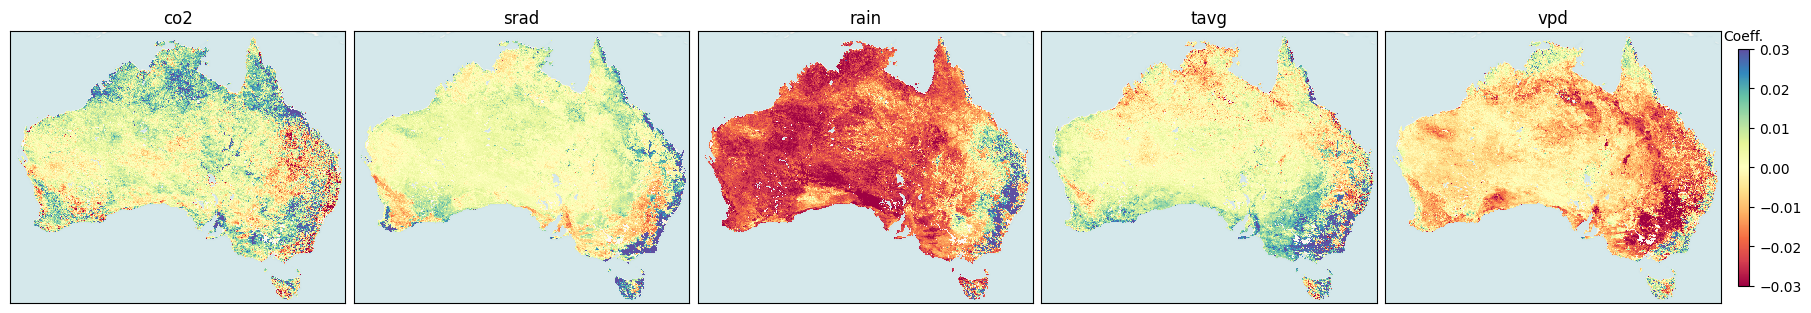

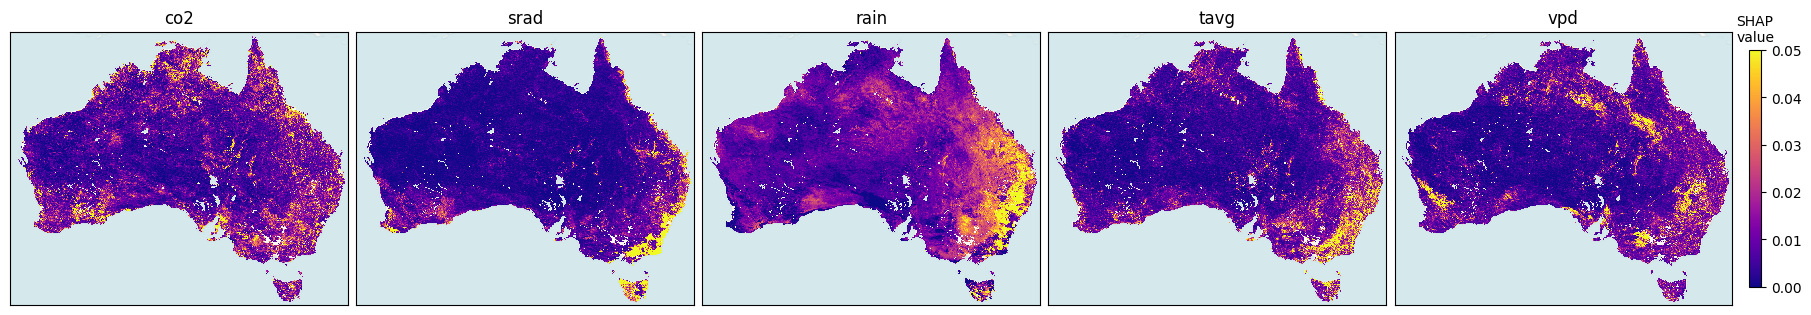

In [4]:
dss = [p_attribution_pls, p_attribution_ml]#, p_attribution_pcmci, p_attribution_delta_slope
variables = ['PLS_coefficent', 'importance',] # 'PCMCI', 'delta_slope'
cmaps = ['Spectral', 'plasma'] #'Spectral', 'plasma'
units = ['Coeff.', 'SHAP\nvalue'] # 'PCMCI', u'ΔSlope'
vmins = [-0.03, 0.0] #-0.75, 0.0
vmaxs = [0.03, 0.05] #0.75, 0.0025

for ds,vars,cmap,u,vmin,vmax, in zip(dss,variables,cmaps,units,vmins,vmaxs):
    fig,axes=plt.subplots(1,5,figsize=(18,6), layout='constrained')
    d = ds[vars]
    for v,ax in zip(d.feature.values, axes.ravel()):
        d.sel(feature=v).plot(add_labels=False,ax=ax,robust=True, cmap=cmap, add_colorbar=False)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_title(v)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.4)
    ax_cbar.ax.set_title(u, fontsize=10);

#### Plot

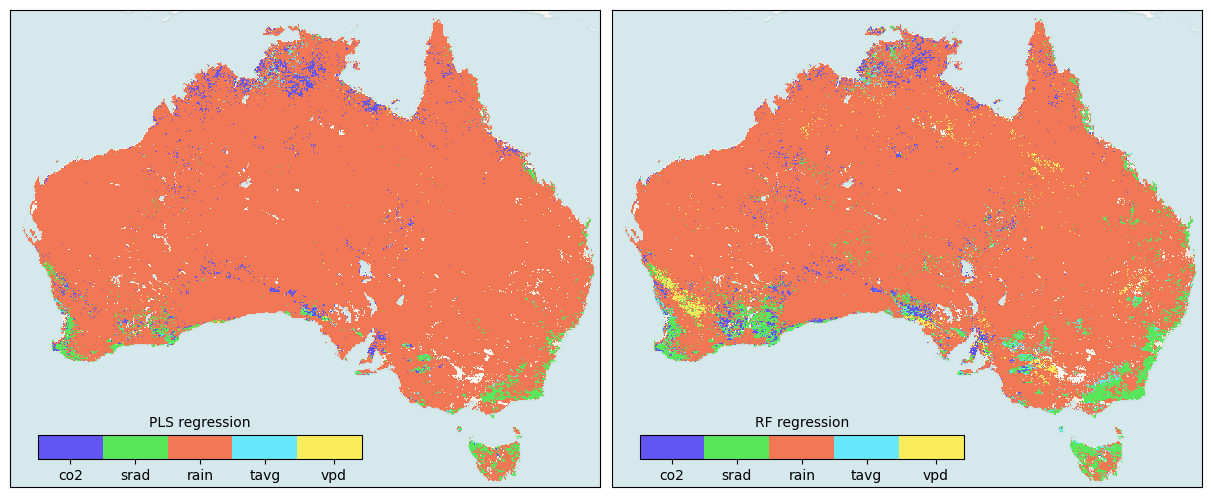

In [5]:
categories = list(p_attribution_pls.feature.values)
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

dss = [
    clim_most_important_var_pls, clim_most_important_var_ml, #clim_most_important_var_pcmci, clim_most_important_var_delta_slope,
    p_attribution_pls, p_attribution_ml#, p_attribution_pcmci, p_attribution_delta_slope
]

names = ['PLS regression', 'RF regression',#, 'PCMCI', u'ΔSlope',
        'PLS regression', 'RF regression'#, 'PCMCI', u'ΔSlope'
        ]

variables = [
    'PLS_coefficent', 'importance',# 'PCMCI', 'delta_slope',
    'PLS_coefficent', 'importance'#, 'PCMCI', 'delta_slope'
]
cmaps = ['plasma', 'plasma', #'plasma', 'plasma',
         'plasma', 'plasma'#, 'plasma', 'plasma'
        ]

units = ['PLS Coefficient', 'SHAP value', #'PCMCI', u'ΔSlope',
         'PLS Coefficient', 'SHAP value'#, 'PCMCI', u'ΔSlope'
        ]


fig,axes=plt.subplots(1,2,figsize=(12,6),layout='constrained', sharey=True, sharex=True)

for ds,n,vars,c,u,ax,i in zip(dss,names,variables,cmaps,units,axes.ravel(),range(len(dss))):
    im = ds.plot(add_colorbar=False,ax=ax, add_labels=False, cmap=cmap)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    axins1 = inset_axes(ax,width="55%",height="5%",loc="lower left", borderpad=2)
    cbar = fig.colorbar(im, cax=axins1, ticks=[0.4,1.2,2,2.8, 3.65],orientation='horizontal')
    cbar.ax.set_xticklabels(categories)
    cbar.ax.set_title(n, fontsize=10)